## CS536: Perceptrons
#### Done by - Vedant Choudhary, vc389
In the usual way, we need data that we can fit and analyze using perceptrons. Consider generating data points (X, Y) in the following way:
- For $i = 1,....,k-1$, let $X_i ~ N(0, 1)$ (i.e. each $X_i$ is an i.i.d. standard normal)
- For $i = k$, generate $X_k$ in the following way: let $D ~ Exp(1)$, and for a parameter $\epsilon > 0$ take

$X_k = (\epsilon + D)$ with probability 1/2

$X_k = -(\epsilon + D)$ with probability 1/2

The effect of this is that while $X_1,...X_{k-1}$ are i.i.d. standard normals, $X_k$ is distributed randomly with some gap (of size $2\epsilon$ around $X_k = 0$. We can then classify each point according to the following:

$Y = 1$ if $X_k$ > 0

$Y = -1$ if $X_k$ < 0

We see that the class of each data point is determined entirely by the value of the $X_k$ feature

#### 1. Show that there is a perceptron that correctly classifies this data. Is this perceptron unique? What is the ‘best’ perceptron for this data set, theoretically?

**Solution:** The perceptron generated when the data is linearly separable is unique. Best perceptron for a data would be the perceptron that relies heaviliy on the last feature of the dataset, as target value is governed by that. What if we train only on the last feature and y?

In [105]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm

%matplotlib inline

In [106]:
a = np.zeros((100,1))
# a.shape (100, 1)
b = np.random.normal(0, 1, (100,19))
# b.shape (100, 19)
np.concatenate((a, b), axis=1).shape

(100, 20)

In [107]:
# Creating X (feature) vectors for the data
def create_data(k, m, D, epsilon):
    X_0 = np.zeros((m, 1))
    X_k_minus_1 = np.random.normal(0, 1, (m,k-1))
    X_k_minus_1 = np.concatenate((X_0, X_k_minus_1), axis=1)
    X_k = []
    for i in range(m):
        temp = np.random.choice(2, 1, p=[0.5,0.5])
#         print(temp)
        if temp == 1:
            X_k.append(epsilon + D)
        else:
            X_k.append(-(epsilon + D))
    X_k = np.asarray(X_k).reshape((m,1))
#     print(X_k_minus_1)
#     print(X_k)
    return np.concatenate((X_k_minus_1, X_k), axis=1)

# Creating target column for the data
def create_y(X, m):
    y = []
    for i in range(m):
        if X[i][-1] > 0:
            y.append(1)
        else:
            y.append(-1)
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m, epsilon, D):
    X = np.asarray(create_data(k, m, epsilon, D))
    y = np.asarray(create_y(X, m)).reshape((m,1))
#     print(X.shape,y.shape)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+2)]+['Y'])
    return data

In [108]:
# Global Variables - k = 20, m = 100, epsilon = 1
k, m, epsilon = 20, 100, 1
D = float(np.random.exponential(1, 1))

train_data = create_dataset(k, m, epsilon, D)
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,Y
0,0.0,0.186240,0.674488,1.430911,-0.965043,-0.854449,0.651747,-1.726295,-0.540467,-1.310553,...,1.385541,-0.102337,0.907492,-0.672645,0.252907,0.874140,0.355671,-0.161363,-2.442685,-1.0
1,0.0,-0.949950,-0.359245,-0.984772,-0.040602,1.769545,-0.529283,-0.129531,1.114470,0.732966,...,-0.926311,-1.851101,-0.925437,-0.171799,-0.147586,0.045173,1.502246,0.128498,2.442685,1.0
2,0.0,0.061207,0.134235,-0.230872,-0.996438,-0.462706,-0.049252,0.009939,-0.159813,0.831188,...,-1.357248,-0.140986,0.055350,0.290007,-0.183480,-0.775398,0.497919,-0.578467,2.442685,1.0
3,0.0,-1.246318,-0.939727,0.664404,-0.576420,1.252830,-1.266086,1.488787,1.823837,1.045521,...,0.154914,0.827893,-0.901686,1.989162,-0.523298,2.558244,-0.279593,0.435948,-2.442685,-1.0
4,0.0,-0.176361,1.311156,-0.327489,-1.320369,1.260440,-0.544994,-2.204486,-1.152690,-0.500229,...,-0.115796,1.275570,-0.128888,0.109000,-2.196567,1.181978,-0.517806,0.315615,2.442685,1.0


In [109]:
# TESTING CODE
X = np.asarray(train_data.iloc[:,:-1])
y = np.asarray(train_data.iloc[:,-1:])
print(X[0].shape, y.shape)
print(y[0])

(21,) (100, 1)
[-1.]


#### 2. We want to consider the problem of learning perceptrons from data sets. Generate a set of data of size m = 100 with k = 20, $\epsilon$ = 1
##### -  Implement the perceptron learning algorithm. This data is separable, so the algorithm will terminate. How does the output perceptron compare to your theoretical answer in the previous problem?

**Solution:** On implementing the perceptron learning algorithm on the dataset provided, we see that it is similar to our theoretical answer. The last feature has highest weight associated to it, because it is responsible for finding the target variable (rules of creating the dataset is such)

In [118]:
# Class for Perceptron
class Perceptron():
    def __init__(self):
        self.termination = 0
    
    def sign_function(self, data_vec):
        return np.array([1 if val >= 1 else -1 for val in data_vec])[:, np.newaxis]
    
    def pla(self, data):
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        num_samples, num_features = X.shape
        
#         Initialize weight parameter (bias included)
        self.w = np.zeros(shape=(num_features, 1))
    
        count_till_solution = 0
        f_x = [0]*num_samples

        while True:
            self.termination += 1
            mismatched = 0
            for i in range(num_samples):
#                 Calculate the mapping function f(x)
                f_x[i] = float(self.sign_function(np.dot(X[i].reshape((num_features, 1)).T, self.w)))

#                 Compute weights if f_x != y
                if float(f_x[i]) != float(y[i]):
                    mismatched += 1
                    self.w += np.dot(X[i].reshape((num_features, 1)), y[i].reshape((1,1)))

            min_margin = 99999
            for i in range(num_samples):
                margin = abs(np.dot(self.w.T, X[i].reshape(-1,1))/(np.linalg.norm(self.w)))
                if margin < min_margin:
                    min_margin = margin
                
            termination = int(1/(min_margin**2))
            f_x = np.asarray(f_x).reshape((num_samples, 1))
            if (np.array_equal(y, f_x)) or (mismatched == 0) or (mismatched > 0.3*num_samples and self.termination > 10000):
                break
                    
        return self.w, self.termination
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector
    Return - predicted value
    '''
    def predict(self, instance_data):
        instance_data = np.asarray(instance_data)
        prediction = self.sign_function(np.dot(self.w.T, instance_data.reshape((len(instance_data),1))))
        return prediction   
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i][:-1])
            if prediction != data.iloc[i][-1]:
                print("Not equal")
                error += 1
        return error/len(data) 
        

In [119]:
perceptron = Perceptron()
final_w, num_steps = perceptron.pla(train_data)
print("Final weights:\n",final_w)
print("Number of steps till convergence: \n", num_steps)

Final weights:
 [[ 0.        ]
 [-1.07421956]
 [-0.75683688]
 [-0.70865079]
 [ 0.77100765]
 [ 1.08423542]
 [-0.24541001]
 [-1.19393494]
 [ 1.98585698]
 [-0.08231506]
 [ 1.01225062]
 [ 1.32064538]
 [ 0.25300628]
 [-0.38204564]
 [-2.4563048 ]
 [-1.06637602]
 [ 0.84868607]
 [-0.27542917]
 [ 0.55440338]
 [-0.98583062]
 [ 4.88537099]]
Number of steps till convergence: 
 2


In [112]:
error = perceptron.fit(train_data)
error

0.0

In [97]:
# final_w.shape (21,1)
# np.linalg.norm(final_w) 8.678673962374873..
# X[0].shape (21,)
# X[0].reshape(-1,1).shape (21,1)
np.dot(X[0].reshape(-1,1).T, final_w)

array([[7.19964018]])

In [98]:
min_margin = 99999
for i in range(m):
    margin = abs(np.dot(final_w.T, X[i].reshape(-1,1))/(np.linalg.norm(final_w)))
    if margin < min_margin:
        min_margin = margin

print(min_margin)
termination = 1/(min_margin**2)
print(termination)

[[0.21512731]]
[[21.60771791]]


In [99]:
1/(((y[0]*(np.dot(X[0].reshape(1, 21), final_w)))/np.linalg.norm(final_w))**2)

array([[1.4530654]])

#### 3. For any given data set, there may be multiple separators with multiple margins - but for our data set, we can effectively control the size of the margin with the parameter $\epsilon$ - the bigger this value, the bigger the margin of our separator.
#### – For m = 100, k = 20, generate a data set for a given value of $\epsilon$ and run the learning algorithm to completion. Plot, as a function of $\epsilon$ ∈ [0, 1], the average or typical number of steps the algorithm needs to terminate. Characterize the dependence.

In [115]:
def varied_margin():
    k, m = 20, 100
    epsilon = list(np.arange(0, 1.1, 0.1))
    avg_steps = []
    for i in range(len(epsilon)):
        D = float(np.random.exponential(1, 1))
        steps = 0
        for j in range(10):
            train_data = create_dataset(k, m, epsilon[i], D)
            perceptron = Perceptron()
            final_w, num_steps = perceptron.pla(train_data)
            steps += num_steps
            
        avg_steps.append(steps/10)
        
    plt.plot(epsilon, avg_steps)
    plt.title("Number of steps w.r.t. margin")
    plt.xlabel("Margin value")
    plt.ylabel("#Steps")
    plt.show()

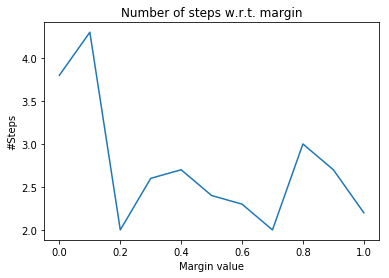

In [59]:
varied_margin()

#### 4. One of the nice properties of the perceptron learning algorithm (and perceptrons generally) is that learning the weight vector w and bias value b is typically independent of the ambient dimension. To see this, consider the following experiment:
#### – Fixing m = 100, $\epsilon$ = 1, consider generating a data set on k features and running the learning algorithm on it. Plot, as a function k (for k = 2, . . . , 40), the typical number of steps to learn a perceptron on a data set of this size. How does the number of steps vary with k? Repeat for m = 1000.

In [137]:
def varied_features(m):
    epsilon = 1
    D = float(np.random.exponential(1, 1))
    k = list(np.arange(2, 40, 2))
    avg_steps = []
    for i in tqdm(range(len(k))):
        steps = []
        for j in range(50):
            train_data = create_dataset(k[i], m, epsilon, D)
            perceptron = Perceptron()
            final_w, num_steps = perceptron.pla(train_data)
            steps.append(num_steps)
    
        avg_steps.append(sum(steps)/len(steps))
   
    plt.plot(k, avg_steps)
    plt.title("Number of steps w.r.t. features")
    plt.xlabel("#Features")
    plt.ylabel("#Steps")
    plt.show()

100%|██████████| 19/19 [00:07<00:00,  2.55it/s]


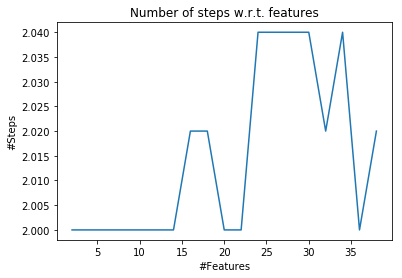

In [138]:
varied_features(100)

100%|██████████| 38/38 [00:27<00:00,  1.30it/s]


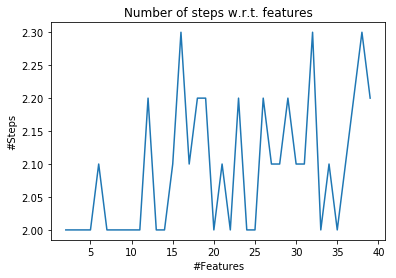

In [130]:
varied_features(1000)

#### 5. As shown in class, the perceptron learning algorithm always terminates in finite time - if there is a separator. Consider generating non-separable data in the following way: generate each $X_1, . . . , X_k$ as i.i.d. standard normals N(0, 1). Define Y by

$$Y = 1 if \sum_{i=1}^k{X_i^2} \ge k $$
$$Y = -1 else$$

In [80]:
def create_non_separable_data(k, m):
    X_0 = np.zeros((m,1))
    X = np.random.normal(0, 1, (m,k))
    X = np.concatenate((X_0, X), axis=1)
    y = []
    for i in range(m):
        total = 0
        for j in range(1, k+1):
            total += X[i][j]**2
        
        if total >= k:
            y.append(1)
        else:
            y.append(-1)
            
    return X, y

def create_non_separable_dataset(k, m):
    X, y = create_non_separable_data(k, m)
    X = np.asarray(X)
    y = np.asarray(y).reshape((m,1))
    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+2)]+['Y'])
    return data

In [81]:
k, m = 2, 100
train_ns_data = create_non_separable_dataset(k, m)
train_ns_data.head()

,X1,X2,X3,Y
0,0.0,-0.091028,-0.350186,-1.0
1,0.0,-0.866504,0.123117,-1.0
2,0.0,-0.384947,1.715332,1.0
3,0.0,-2.378423,-1.058008,1.0
4,0.0,-1.196985,-1.569219,1.0


In [104]:
perceptron2 = Perceptron()
final_w2, num_steps2 = perceptron2.pla(train_ns_data)

1 31
2 31
3 30
4 38
5 31
6 31
7 33
8 31
9 33
10 33
11 31
12 32
13 33
14 33
15 33
16 30
17 31
18 31
19 30
20 31
21 33
22 31
23 31
24 33
25 29
26 30
27 31
28 33
29 31
30 30
31 31
32 31
33 33
34 31
35 31
36 33
37 31
38 30
39 31
40 36
41 33
42 31
43 31
44 32
45 33
46 33
47 30
48 31
49 31
50 30
51 34
52 35
53 28
54 38
55 31
56 33
57 30
58 31
59 31
60 30
61 31
62 33
63 31
64 31
65 33
66 29
67 30
68 31
69 33
70 31
71 30
72 31
73 31
74 33
75 31
76 31
77 37
78 31
79 30
80 31
81 31
82 32
83 33
84 30
85 31
86 36
87 32
88 33
89 33
90 30
91 31
92 32
93 33
94 33
95 33
96 30
97 31
98 31
99 30
100 31
101 33
102 31
103 31
104 32
105 30
106 36
107 33
108 31
109 31
110 33
111 31
112 31
113 33
114 29
115 30
116 31
117 32
118 33
119 33
120 33
121 30
122 31
123 31
124 32
125 33
126 30
127 31
128 36
129 32
130 33
131 33
132 30
133 31
134 31
135 30
136 34
137 33
138 33
139 33
140 33
141 33
142 34
143 31
144 30
145 31
146 33
147 31
148 33
149 33
150 33
151 31
152 32
153 33
154 33
155 30
156 31
157 31
158 32
15

1186 33
1187 31
1188 31
1189 37
1190 31
1191 30
1192 31
1193 31
1194 32
1195 33
1196 30
1197 31
1198 36
1199 32
1200 33
1201 33
1202 30
1203 31
1204 32
1205 33
1206 33
1207 33
1208 30
1209 31
1210 31
1211 30
1212 31
1213 33
1214 31
1215 31
1216 32
1217 30
1218 36
1219 33
1220 31
1221 31
1222 33
1223 31
1224 31
1225 33
1226 29
1227 30
1228 31
1229 32
1230 33
1231 33
1232 33
1233 30
1234 31
1235 31
1236 32
1237 33
1238 30
1239 31
1240 36
1241 32
1242 33
1243 33
1244 30
1245 31
1246 31
1247 30
1248 34
1249 33
1250 33
1251 33
1252 33
1253 33
1254 34
1255 31
1256 30
1257 31
1258 33
1259 31
1260 33
1261 33
1262 33
1263 31
1264 32
1265 33
1266 33
1267 30
1268 31
1269 31
1270 32
1271 33
1272 30
1273 31
1274 31
1275 32
1276 33
1277 30
1278 31
1279 36
1280 32
1281 33
1282 33
1283 30
1284 31
1285 31
1286 30
1287 31
1288 33
1289 31
1290 31
1291 32
1292 30
1293 36
1294 33
1295 31
1296 31
1297 33
1298 31
1299 31
1300 33
1301 31
1302 31
1303 32
1304 33
1305 33
1306 30
1307 31
1308 31
1309 32
1310 33


2319 31
2320 33
2321 31
2322 31
2323 32
2324 30
2325 36
2326 33
2327 31
2328 31
2329 33
2330 31
2331 31
2332 33
2333 31
2334 31
2335 32
2336 33
2337 33
2338 30
2339 31
2340 31
2341 30
2342 31
2343 33
2344 31
2345 31
2346 33
2347 31
2348 33
2349 33
2350 31
2351 32
2352 33
2353 33
2354 33
2355 30
2356 31
2357 31
2358 30
2359 31
2360 33
2361 31
2362 31
2363 32
2364 30
2365 36
2366 33
2367 31
2368 31
2369 33
2370 31
2371 31
2372 33
2373 31
2374 31
2375 32
2376 33
2377 33
2378 30
2379 31
2380 31
2381 30
2382 31
2383 33
2384 31
2385 31
2386 33
2387 31
2388 33
2389 33
2390 31
2391 32
2392 33
2393 33
2394 33
2395 30
2396 31
2397 31
2398 30
2399 31
2400 33
2401 31
2402 31
2403 32
2404 30
2405 36
2406 33
2407 31
2408 31
2409 33
2410 31
2411 31
2412 33
2413 31
2414 31
2415 32
2416 33
2417 33
2418 30
2419 31
2420 31
2421 30
2422 31
2423 33
2424 31
2425 31
2426 33
2427 31
2428 33
2429 33
2430 31
2431 32
2432 33
2433 33
2434 33
2435 30
2436 31
2437 31
2438 30
2439 31
2440 33
2441 31
2442 31
2443 32


3391 30
3392 31
3393 33
3394 31
3395 33
3396 33
3397 33
3398 31
3399 32
3400 33
3401 33
3402 30
3403 31
3404 31
3405 32
3406 33
3407 30
3408 31
3409 31
3410 32
3411 33
3412 30
3413 31
3414 36
3415 32
3416 33
3417 33
3418 30
3419 31
3420 31
3421 30
3422 31
3423 33
3424 31
3425 31
3426 33
3427 29
3428 30
3429 31
3430 33
3431 31
3432 30
3433 31
3434 31
3435 33
3436 31
3437 31
3438 37
3439 31
3440 30
3441 31
3442 31
3443 32
3444 33
3445 30
3446 31
3447 36
3448 32
3449 33
3450 33
3451 30
3452 31
3453 32
3454 33
3455 33
3456 33
3457 30
3458 31
3459 31
3460 30
3461 31
3462 33
3463 31
3464 31
3465 32
3466 30
3467 36
3468 33
3469 31
3470 31
3471 33
3472 31
3473 31
3474 33
3475 29
3476 30
3477 31
3478 32
3479 33
3480 33
3481 33
3482 30
3483 31
3484 31
3485 32
3486 33
3487 30
3488 31
3489 36
3490 32
3491 33
3492 33
3493 30
3494 31
3495 31
3496 30
3497 34
3498 33
3499 33
3500 33
3501 33
3502 33
3503 34
3504 31
3505 30
3506 31
3507 33
3508 31
3509 33
3510 33
3511 33
3512 31
3513 32
3514 33
3515 33


4476 33
4477 31
4478 31
4479 33
4480 31
4481 31
4482 33
4483 31
4484 31
4485 32
4486 33
4487 33
4488 30
4489 31
4490 31
4491 32
4492 33
4493 30
4494 31
4495 31
4496 32
4497 33
4498 30
4499 31
4500 36
4501 32
4502 33
4503 33
4504 30
4505 31
4506 32
4507 33
4508 33
4509 33
4510 30
4511 31
4512 31
4513 32
4514 33
4515 30
4516 31
4517 33
4518 31
4519 33
4520 31
4521 31
4522 33
4523 31
4524 30
4525 31
4526 36
4527 33
4528 31
4529 31
4530 32
4531 34
4532 31
4533 31
4534 32
4535 33
4536 33
4537 30
4538 31
4539 31
4540 32
4541 33
4542 30
4543 31
4544 33
4545 31
4546 30
4547 31
4548 36
4549 33
4550 31
4551 31
4552 33
4553 31
4554 31
4555 32
4556 33
4557 33
4558 30
4559 31
4560 31
4561 30
4562 31
4563 33
4564 31
4565 31
4566 33
4567 29
4568 30
4569 31
4570 33
4571 31
4572 30
4573 31
4574 31
4575 33
4576 31
4577 31
4578 33
4579 31
4580 30
4581 31
4582 36
4583 33
4584 31
4585 31
4586 32
4587 33
4588 33
4589 30
4590 31
4591 31
4592 30
4593 34
4594 33
4595 34
4596 33
4597 30
4598 31
4599 32
4600 33


5509 32
5510 33
5511 30
5512 31
5513 31
5514 32
5515 33
5516 30
5517 31
5518 36
5519 32
5520 33
5521 33
5522 30
5523 31
5524 31
5525 30
5526 31
5527 33
5528 31
5529 31
5530 32
5531 30
5532 36
5533 33
5534 31
5535 31
5536 33
5537 31
5538 31
5539 33
5540 31
5541 31
5542 32
5543 33
5544 33
5545 30
5546 31
5547 31
5548 32
5549 33
5550 30
5551 31
5552 31
5553 32
5554 33
5555 30
5556 31
5557 36
5558 32
5559 33
5560 33
5561 30
5562 31
5563 31
5564 30
5565 34
5566 33
5567 33
5568 33
5569 33
5570 33
5571 34
5572 31
5573 30
5574 31
5575 33
5576 31
5577 33
5578 33
5579 33
5580 31
5581 32
5582 33
5583 33
5584 30
5585 31
5586 31
5587 32
5588 33
5589 30
5590 31
5591 31
5592 32
5593 33
5594 30
5595 31
5596 36
5597 32
5598 33
5599 33
5600 30
5601 31
5602 31
5603 30
5604 31
5605 33
5606 31
5607 31
5608 32
5609 30
5610 36
5611 33
5612 31
5613 31
5614 33
5615 31
5616 31
5617 33
5618 31
5619 31
5620 32
5621 33
5622 33
5623 30
5624 31
5625 31
5626 32
5627 33
5628 30
5629 31
5630 31
5631 32
5632 33
5633 30


6601 33
6602 31
6603 31
6604 33
6605 31
6606 31
6607 32
6608 33
6609 33
6610 30
6611 31
6612 31
6613 30
6614 31
6615 33
6616 31
6617 31
6618 33
6619 31
6620 33
6621 33
6622 31
6623 32
6624 33
6625 33
6626 33
6627 30
6628 31
6629 31
6630 30
6631 31
6632 33
6633 31
6634 31
6635 32
6636 30
6637 36
6638 33
6639 33
6640 30
6641 31
6642 31
6643 32
6644 33
6645 30
6646 31
6647 31
6648 32
6649 33
6650 30
6651 31
6652 36
6653 32
6654 33
6655 33
6656 30
6657 31
6658 31
6659 30
6660 34
6661 33
6662 33
6663 33
6664 33
6665 33
6666 33
6667 31
6668 32
6669 33
6670 33
6671 30
6672 31
6673 31
6674 32
6675 33
6676 30
6677 31
6678 31
6679 32
6680 33
6681 30
6682 31
6683 36
6684 32
6685 33
6686 33
6687 30
6688 31
6689 31
6690 30
6691 34
6692 35
6693 28
6694 38
6695 31
6696 33
6697 30
6698 31
6699 31
6700 30
6701 31
6702 33
6703 31
6704 31
6705 33
6706 31
6707 33
6708 33
6709 31
6710 32
6711 33
6712 33
6713 30
6714 31
6715 31
6716 32
6717 33
6718 30
6719 31
6720 31
6721 32
6722 33
6723 30
6724 31
6725 36


7701 31
7702 33
7703 31
7704 31
7705 33
7706 31
7707 33
7708 33
7709 34
7710 31
7711 31
7712 36
7713 33
7714 31
7715 31
7716 33
7717 31
7718 31
7719 33
7720 29
7721 30
7722 31
7723 31
7724 30
7725 31
7726 33
7727 31
7728 31
7729 32
7730 30
7731 36
7732 33
7733 31
7734 31
7735 33
7736 31
7737 31
7738 33
7739 31
7740 31
7741 32
7742 33
7743 33
7744 30
7745 31
7746 31
7747 30
7748 31
7749 33
7750 31
7751 31
7752 32
7753 30
7754 36
7755 33
7756 31
7757 31
7758 33
7759 31
7760 31
7761 33
7762 29
7763 30
7764 31
7765 31
7766 30
7767 31
7768 33
7769 31
7770 31
7771 32
7772 30
7773 36
7774 33
7775 31
7776 31
7777 33
7778 31
7779 31
7780 33
7781 31
7782 31
7783 32
7784 33
7785 33
7786 30
7787 31
7788 31
7789 30
7790 31
7791 33
7792 31
7793 31
7794 32
7795 30
7796 36
7797 33
7798 31
7799 31
7800 33
7801 31
7802 31
7803 33
7804 29
7805 30
7806 31
7807 31
7808 30
7809 31
7810 33
7811 31
7812 31
7813 32
7814 30
7815 36
7816 33
7817 31
7818 31
7819 33
7820 31
7821 31
7822 33
7823 31
7824 31
7825 32


8794 30
8795 31
8796 31
8797 32
8798 33
8799 30
8800 31
8801 36
8802 32
8803 33
8804 33
8805 30
8806 31
8807 31
8808 30
8809 34
8810 35
8811 28
8812 38
8813 31
8814 33
8815 30
8816 31
8817 31
8818 30
8819 31
8820 33
8821 31
8822 31
8823 33
8824 31
8825 33
8826 33
8827 31
8828 32
8829 33
8830 33
8831 30
8832 31
8833 31
8834 32
8835 33
8836 30
8837 31
8838 31
8839 32
8840 33
8841 30
8842 31
8843 36
8844 32
8845 33
8846 33
8847 30
8848 31
8849 31
8850 30
8851 31
8852 33
8853 31
8854 31
8855 32
8856 30
8857 36
8858 33
8859 31
8860 31
8861 33
8862 31
8863 31
8864 33
8865 31
8866 31
8867 32
8868 33
8869 33
8870 30
8871 31
8872 31
8873 32
8874 33
8875 30
8876 31
8877 31
8878 32
8879 33
8880 30
8881 31
8882 36
8883 32
8884 33
8885 33
8886 30
8887 31
8888 31
8889 30
8890 34
8891 33
8892 33
8893 33
8894 33
8895 33
8896 34
8897 31
8898 30
8899 31
8900 33
8901 31
8902 33
8903 33
8904 33
8905 31
8906 32
8907 33
8908 33
8909 30
8910 31
8911 31
8912 32
8913 33
8914 30
8915 31
8916 31
8917 32
8918 34


9840 31
9841 31
9842 32
9843 34
9844 31
9845 31
9846 32
9847 33
9848 33
9849 30
9850 31
9851 31
9852 32
9853 33
9854 30
9855 31
9856 33
9857 31
9858 30
9859 31
9860 36
9861 33
9862 31
9863 31
9864 33
9865 31
9866 31
9867 32
9868 33
9869 33
9870 30
9871 31
9872 31
9873 30
9874 31
9875 33
9876 31
9877 31
9878 32
9879 30
9880 36
9881 33
9882 33
9883 30
9884 31
9885 31
9886 30
9887 31
9888 33
9889 31
9890 31
9891 33
9892 31
9893 33
9894 33
9895 34
9896 31
9897 31
9898 36
9899 33
9900 31
9901 31
9902 33
9903 31
9904 31
9905 33
9906 29
9907 30
9908 31
9909 31
9910 30
9911 31
9912 33
9913 31
9914 31
9915 32
9916 30
9917 36
9918 33
9919 31
9920 31
9921 33
9922 31
9923 31
9924 33
9925 31
9926 31
9927 32
9928 33
9929 33
9930 30
9931 31
9932 31
9933 32
9934 33
9935 30
9936 31
9937 33
9938 31
9939 33
9940 31
9941 31
9942 33
9943 31
9944 30
9945 31
9946 36
9947 33
9948 31
9949 31
9950 32
9951 34
9952 31
9953 31
9954 32
9955 33
9956 33
9957 30
9958 31
9959 31
9960 32
9961 33
9962 30
9963 31
9964 33
